In [1]:
# ! pip install matplotlib ipywidgets numpy ipympl

In [2]:
%matplotlib widget
import ipywidgets as widgets
from ipywidgets import interact, FloatSlider
import matplotlib.pyplot as plt
import numpy as np

In [3]:
t = np.linspace(0, 5, 10000) # s

inversion_eff = 0.85
partition = 0.83 # mL/g
cbf = 0.8 # mL/mLs
T1_tissue = 1.5 # s
T1_blood = 1.65 # s
labelling_duration = 0.275 # s
pld = 2 # s

In [4]:
def continuous_asl_signal(inversion_eff, partition, cbf, 
                          T1_tissue, T1_blood, labelling_duration, pld):
    T1_prime = (1/T1_tissue + cbf/partition) ** -1
    q_steady_state = np.zeros_like(t)
    delta_mag = np.zeros_like(t)
    bolus = (pld < t) & (t < pld + labelling_duration)
    after = pld + labelling_duration <= t
    q_steady_state[bolus] = 1 - np.exp(-(t[bolus] - pld)/T1_prime)
    q_steady_state[after] = 1 - np.exp(-labelling_duration/T1_prime)
    ampl = 2 * cbf * T1_prime * inversion_eff
    delta_mag[bolus] = ampl * np.exp(-pld/T1_blood)
    delta_mag[after] = ampl * np.exp(-pld/T1_blood - (t[after] - pld - labelling_duration)/T1_prime)
    return delta_mag * q_steady_state

interactive(children=(FloatSlider(value=0.85, description='inversion_eff', max=1.0, min=0.4, step=0.02), Float…

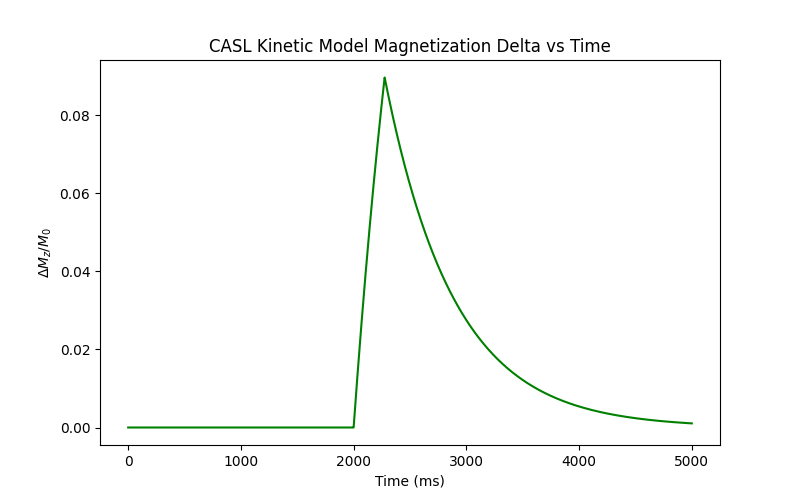

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))
plt.title('CASL Kinetic Model Magnetization Delta vs Time')
plt.xlabel('Time (ms)')
plt.ylabel("$\Delta M_z/M_0$")

@widgets.interact(inversion_eff=(0.4, 1, 0.02), partition=(0.2, 0.94, 0.02), cbf=(0.2, 4.5, 0.05), 
                  T1_tissue=(1, 1.8, 0.05), T1_blood=(1.1, 1.9, 0.05), labelling_duration=(0.05, 3.5, 0.025),
                  pld=(0.5, 4, 0.1))
def update(inversion_eff=inversion_eff, partition=partition, cbf=cbf, 
           T1_tissue=T1_tissue, T1_blood=T1_blood, labelling_duration=labelling_duration, pld=pld):
    # https://stackoverflow.com/a/63548700/2561747
    for line in ax.get_lines():
        line.remove()
    
    delta_mag = continuous_asl_signal(inversion_eff, partition, cbf, 
                                      T1_tissue, T1_blood, labelling_duration, pld)
    ax.plot(t * 1000, delta_mag, 'green')